In [ ]:
#Installing required packages
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0  --quiet

In [ ]:
# Importing necessary libraries
import pandas as pd
import gzip
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, roc_auc_score, mean_absolute_error
from google.colab import drive
from sklearn.metrics import roc_curve, auc
import numpy as np
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from datasets import Dataset
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load dataset from JSON gzip file
file_path = '/content/drive/MyDrive/AMAZON_FASHION.json.gz'

with gzip.open(file_path) as f:
  df = pd.read_json(f, lines = True, nrows= 100000)

In [ ]:
print(df.shape)

(100000, 12)


In [ ]:
# Selecting only a subset of columns from the dataframe
df_new = df[['overall','verified','reviewTime','reviewText']]

In [ ]:
# Checking for missing values in the dataframe
df_new.isna().sum()

overall         0
verified        0
reviewTime      0
reviewText    109
dtype: int64

In [ ]:
# Filtering out rows where 'verified' column is False
df_drop = df_new.drop(df_new[df_new['verified']==False].index)
df = df_drop.reset_index(drop = True)

In [ ]:
# Removing rows with missing 'reviewText' or 'overall'
df = df.dropna(subset=['reviewText', 'overall'])

In [ ]:
# Adjusting the 'overall' rating by subtracting 1
df['overall'] = df['overall'] - 1

In [ ]:
# Splitting the dataframe into train and test datasets
df_test = df.iloc [:1000, :].reset_index(drop=True)
df_train = df.iloc[1000:, : ].reset_index(drop=True)
print(df_train.shape)
print(df_test.shape)

(92601, 4)
(1000, 4)


In [ ]:
# Converting pandas dataframe to HuggingFace's dataset format
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)
print(train_dataset.shape)
print(test_dataset.shape)

(92601, 4)
(1000, 4)


Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors


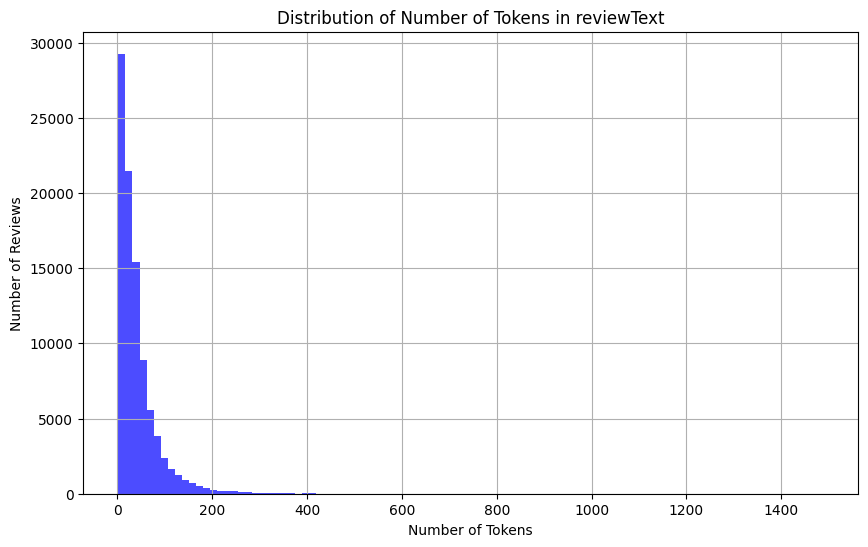

In [ ]:
# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Checking and visualizing the token distribution in the reviews
df['num_tokens'] = df['reviewText'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))

# Plot the distribution
plt.figure(figsize=(10,6))
plt.hist(df['num_tokens'], bins=100, facecolor='blue', alpha=0.7)
plt.title('Distribution of Number of Tokens in reviewText')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

In [ ]:
# Tokenization function for the dataset
def tokenize(batch):
    tokenized_inputs = tokenizer(batch['reviewText'], padding=True, truncation=True, max_length=128, return_tensors='pt')
    tokenized_inputs["labels"] = torch.tensor(batch['overall'])
    return tokenized_inputs

# Applying the tokenization function on test datasets
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Setting the format for the datasets
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [ ]:
test_dataset

Dataset({
    features: ['overall', 'verified', 'reviewTime', 'reviewText', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})

In [ ]:
# Initializing the model
model = AutoModelForSequenceClassification.from_pretrained(
    'minamhd/BERT_Amazon_Review',
    num_labels=len(np.unique(df['overall']))
)


In [ ]:
# Setting up training configurations
training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=128,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    logging_steps=10,
)


In [ ]:
# Function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions

    # Hard predictions are needed for accuracy, precision, recall, and F1
    hard_preds = np.argmax(preds, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, hard_preds, average='weighted')
    acc = accuracy_score(labels, hard_preds)
    mae = mean_absolute_error(labels, hard_preds)

    # Compute ROC AUC for each class
    roc_auc = {}
    for i in range(preds.shape[1]):  # Iterate over each class
        roc_auc[f"roc_auc_class_{i}"] = roc_auc_score((labels == i).astype(int), preds[:, i])

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'mae': mae,
        **roc_auc  # This will expand the dictionary to include the roc_auc for each class
    }

# Initializing the trainer with the model, configurations, datasets, and metrics
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
# Training the model
trainer.evaluate()

{'eval_loss': 0.779782235622406,
 'eval_accuracy': 0.683,
 'eval_f1': 0.6613275199126593,
 'eval_precision': 0.6569764302059498,
 'eval_recall': 0.683,
 'eval_mae': 0.372,
 'eval_roc_auc_class_0': 0.9666713367269104,
 'eval_roc_auc_class_1': 0.9280851063829786,
 'eval_roc_auc_class_2': 0.8901864308254442,
 'eval_roc_auc_class_3': 0.6858523494641573,
 'eval_roc_auc_class_4': 0.8718496033281734,
 'eval_runtime': 7.8256,
 'eval_samples_per_second': 127.785,
 'eval_steps_per_second': 1.022}

In [ ]:
# Evaluate the model on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

true_labels = test_dataset['overall']

# Computing metrics for the predictions
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Printing the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Accuracy: 0.683
Precision: 0.6569764302059498
Recall: 0.683
F1-Score: 0.6613275199126593


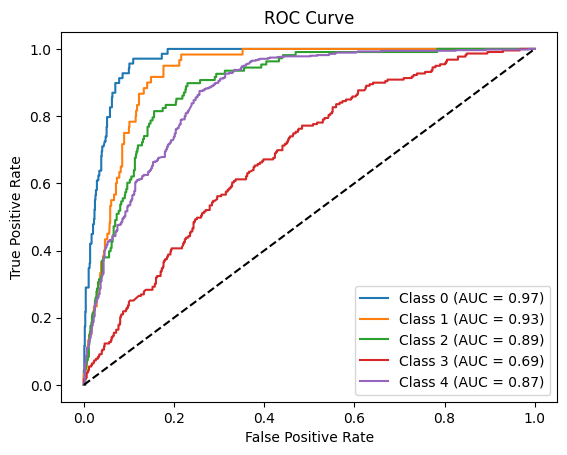

In [ ]:
# Calculating and plotting the ROC curve for the predictions
predicted_probabilities = predictions.predictions

true_labels = test_dataset['overall']
num_classes = len(np.unique(true_labels))

# Convert true labels and predicted probabilities to one-hot encoded format
true_labels_one_hot = label_binarize(true_labels, classes=np.arange(num_classes))

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Store embeddings
cls_embeddings = []
mean_pooled_embeddings = []

# Extract input data from the test dataset
input_ids = test_dataset['input_ids']
attention_mask = test_dataset['attention_mask']

# Convert input data to tensors and move them to the same device as the model
input_ids = torch.tensor(input_ids).to(device)
attention_mask = torch.tensor(attention_mask).to(device)

# Disable gradient calculations
with torch.no_grad():
    for input_id, attention_mask in zip(input_ids, attention_mask):
        # Forward pass, return hidden states
        outputs = model(input_ids=input_id.unsqueeze(0).to(device),
                        attention_mask=attention_mask.unsqueeze(0).to(device),
                        output_hidden_states=True)

        # Extract embeddings from the hidden states
        hidden_states = outputs.hidden_states
        last_hidden_state = hidden_states[-1]  # The last layer hidden state

        # [CLS] token embeddings
        cls_embedding = last_hidden_state[:, 0, :].detach().cpu().numpy()
        cls_embeddings.append(cls_embedding.flatten())

        # Mean pooling
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        mean_pooled_embedding = (sum_embeddings / sum_mask).detach().cpu().numpy()
        mean_pooled_embeddings.append(mean_pooled_embedding.flatten())

<ipython-input-49-d65f2e920a0f>:13: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-49-d65f2e920a0f>:14: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [ ]:
# Convert lists to numpy arrays
cls_embeddings = np.array(cls_embeddings)
mean_pooled_embeddings = np.array(mean_pooled_embeddings)

print(cls_embeddings.shape)
print(mean_pooled_embeddings.shape)


(1000, 768)
(1000, 768)


In [ ]:

# Apply t-SNE
tsne_cls = TSNE(n_components=2, random_state=42).fit_transform(cls_embeddings)
tsne_mean_pooled = TSNE(n_components=2, random_state=42).fit_transform(mean_pooled_embeddings)


In [ ]:
labels = test_dataset['labels'] +1  # Extract labels
review_texts = test_dataset['reviewText']  # Extract review texts

# Prepare the data for Plotly plots
plot_data_cls = {'t-SNE Dimension 1': tsne_cls[:, 0],
                 't-SNE Dimension 2': tsne_cls[:, 1],
                 'Label': labels,
                 'Review Text': review_texts}

plot_data_mean_pooled = {'t-SNE Dimension 1': tsne_mean_pooled[:, 0],
                         't-SNE Dimension 2': tsne_mean_pooled[:, 1],
                         'Label': labels,
                         'Review Text': review_texts}


# Customize colorbar to show integer labels
colorbar_tickvals = list(range(1, 6))
colorbar_ticktext = [str(val) for val in colorbar_tickvals]

# Plotting with Plotly - [CLS] Token Embeddings
fig_cls = px.scatter(plot_data_cls, x='t-SNE Dimension 1', y='t-SNE Dimension 2',
                     color='Label', hover_data={'t-SNE Dimension 1': False, 't-SNE Dimension 2': False, 'Review Text': True})


fig_cls.update_layout(title='t-SNE of [CLS] Token Embeddings with Labels', height=700,  font=dict(
        size=20,
))
fig_cls.update_traces(marker=dict(size=10, opacity=0.9))

fig_cls.update_layout(coloraxis_colorbar=dict(
    tickvals=colorbar_tickvals,
    ticktext=colorbar_ticktext
))

fig_cls.show()

# Plotting with Plotly - Mean Pooled Embeddings
fig_mean_pooled = px.scatter(plot_data_mean_pooled, x='t-SNE Dimension 1', y='t-SNE Dimension 2',
                             color='Label', hover_data={'t-SNE Dimension 1': False, 't-SNE Dimension 2': False, 'Review Text': True})
fig_mean_pooled.update_layout(title='t-SNE of Mean Pooled Embeddings with Labels', height=700,  font=dict(
        size=20,
    ))

fig_mean_pooled.update_layout(coloraxis_colorbar=dict(
    tickvals=colorbar_tickvals,
    ticktext=colorbar_ticktext
))
fig_mean_pooled.update_traces(marker=dict(size=10, opacity=0.9))
fig_mean_pooled.show()

In [ ]:
""